In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

In [10]:
# Load cleaned dataset
df = pd.read_csv('../data/processed/train_clean.csv')
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats


Note: Right now we'll model only toxic label (binary classification).

In [11]:
# Train Test Split
# -----------------------------------------------------
# Input features
X = df['clean_comment']
# Target labels (binary classification: 'toxic' vs 'non-toxic')
y = df['toxic']

# 80% train, 20% test
# stratify=y ensures label balance in train/test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Text Vectorization TF-IDF
# -----------------------------------------------------
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,   # You can tune this
    ngram_range=(1,2),    # Use unigrams + bigrams
    stop_words='english'  # Remove stopwords again (safe for classical models)
)

# Fit on train only, then transform train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [38]:
# Logistic Regression
# -----------------------------------------------------
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# PREDICT
# 0. Predict Probabilities
y_probs = logreg.predict_proba(X_test_tfidf)[:, 1]

# 1. Predict with default threshold = 0.5
y_pred_default = (y_probs >= 0.5).astype(int)

# 2. Predict with custom threshold (e.g., 0.4)
LR_THRES = 0.25
y_pred_custom = (y_probs >= LR_THRES).astype(int)

In [ ]:
# EVALUATE
print("Classification Report - Logistic Regression")
print(classification_report(y_test, y_pred_custom))

Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28843
           1       0.78      0.75      0.76      3059

    accuracy                           0.96     31902
   macro avg       0.88      0.86      0.87     31902
weighted avg       0.95      0.96      0.96     31902



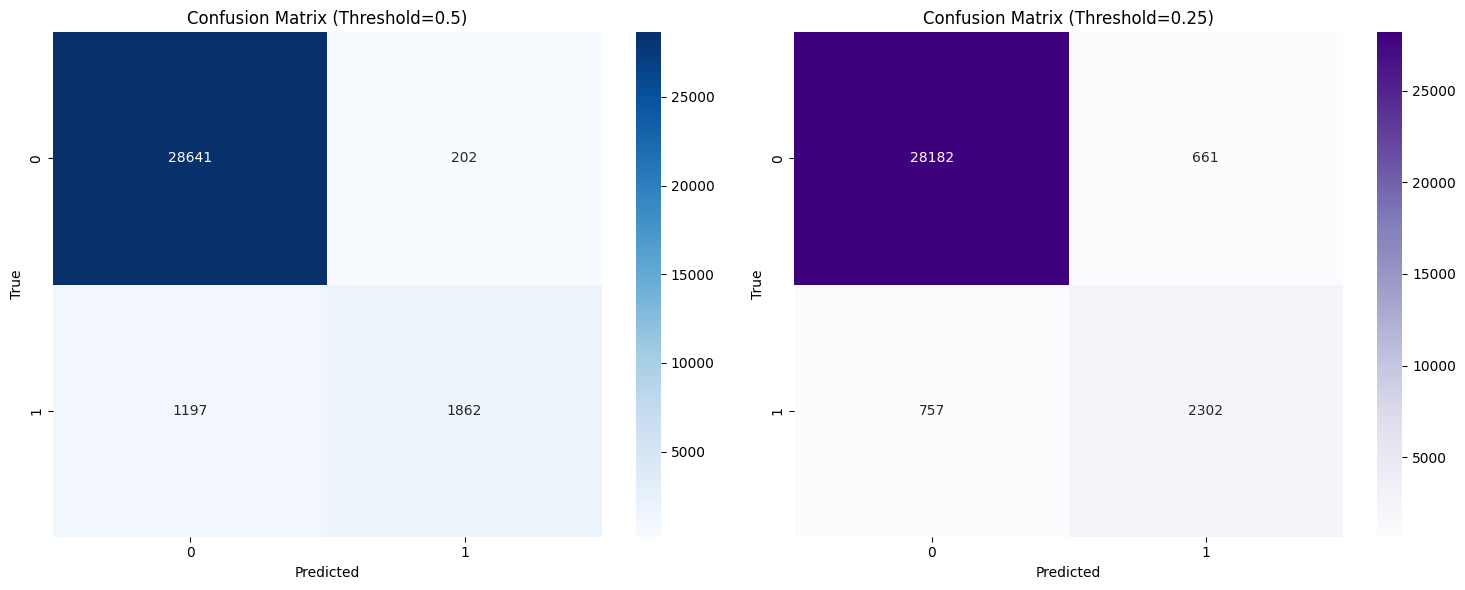

In [40]:
# Confusion Matrix
cm_default = confusion_matrix(y_test, y_pred_default)
cm_custom = confusion_matrix(y_test, y_pred_custom)

fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Default threshold 0.5
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Threshold=0.5)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Custom threshold
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Purples', ax=axes[1])
axes[1].set_title(f'Confusion Matrix (Threshold={LR_THRES})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Summary:
<br>After tuning the threshold from default 0.5 to 0.25, the model improved its ability to detect toxic comments by significantly increasing true positive detections and reducing false negatives. Although there was an increase in false positives, this is an acceptable trade-off in toxicity classification tasks where failing to detect toxic comments is more harmful than over-flagging.

<br>What happens when I lower the LR threshold
<br>1. True Positives (TP) Increased a lot
* From 1,862 → 2,302 toxic comments correctly detected.
* Gain of +440 correct toxic detections.
<br>➡️ This is a good sign because I care about catching toxic comments

<br>2. False Positives (FP) Increased too
* From 202 → 661 non-toxic comments wrongly flagged as toxic.
* Loss of +459 false alarms.
<br>➡️ This means the model is more aggressive — more false alarms.

#### Precision-Recall Curve
<br> Precision measures the ability of a model to correctly identify positive instances, while recall measures its ability to find all relevant positive instances. 

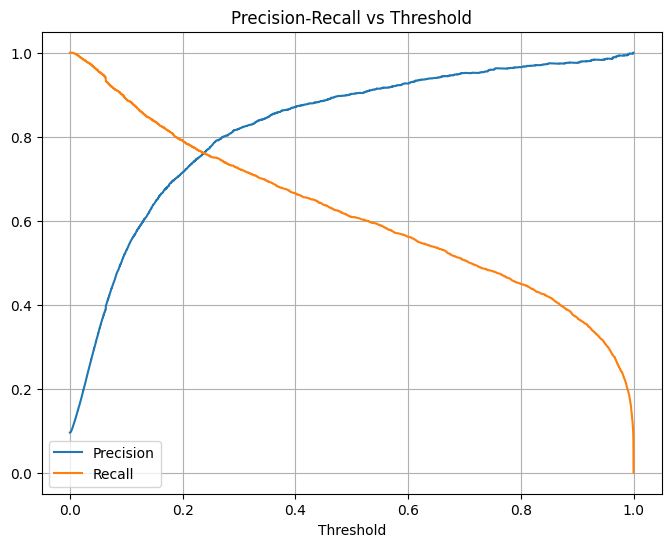

In [37]:
# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

### SVM

In [ ]:
# SVM (Linear Kernel)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train)

# PREDICT
y_pred_svm = svm.predict(X_test_tfidf)


In [ ]:
print("Classification Report - SVM")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()
